In [1]:
## imports 
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation, binary_erosion, binary_closing
from fastmri.data import transforms, subsample
import nibabel as nib
import torch
import sigpy as sp
import cfl

In [5]:
# Utils 
# Mask generation function
def create_brain_masks(mri_scan, loose_padding=5, hole_structre=5):
    # Normalize the scan to ensure values are between 0 and 1
    normalized_scan = (mri_scan - mri_scan.min()) / (mri_scan.max() - mri_scan.min())

    # Create a tight mask by thresholding
    tight_mask = normalized_scan > 0.1  # Assuming black background with very low intensity

    # Fill holes in the tight mask using binary closing
    structure = np.ones((hole_structre, hole_structre))  # Define the structure for morphological operations
    tight_mask = binary_closing(tight_mask, structure=structure)

    # Create a loose mask by applying dilation to the tight mask
    loose_mask = binary_dilation(tight_mask, structure=structure, iterations=loose_padding)

    return tight_mask.astype(np.uint8), loose_mask.astype(np.uint8)

# Undersampling function 
def get_mask_func(factor):
    center_fractions = 0.08 * 4/factor # RandomMaskFunc EquiSpacedMaskFunc
    mask_func = subsample.EquiSpacedMaskFunc(
    center_fractions=[center_fractions],
    accelerations=[factor], 
    )
    return mask_func

def ifft2c(kspace):

    return np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(kspace, axes=(0, 1)), axes=(0, 1)), axes=(0, 1))

def fft2c(image):
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(image, axes=(0, 1)), axes=(0, 1)), axes=(0, 1))
def calc_NRMSE(I_pred,I_true):    
        # Reshape the images into vectors
        I_true = np.reshape(I_true,(1,-1))   
        I_pred = np.reshape(I_pred,(1,-1))               
        # Mean Square Error
        MSE = np.square(np.subtract(I_true,I_pred)).mean()       
        # Root Mean Square Error
        RMSE = np.sqrt(MSE)
        # Normalized Root Mean Square Error
        rr = np.max(I_true) - np.min(I_true) # range
        NRMSE = RMSE/rr
        return NRMSE
def to_numpy(x):
    """
    Convert real-valued PyTorch tensor to complex-valued numpy array.
    """
    assert x.size(-1) == 2
    x = x.numpy()
    return x[..., 0] + 1j*x[..., 1]

    
def to_tensor(x):
    """
    Convert complex-valued numpy array to real-valued PyTorch tensor. 
    """
    x = np.stack((x.real, x.imag), axis=-1)
    return torch.from_numpy(x)
def crop_image_vertical(data, crop_fraction=0.2):
    """
    Crops the upper and lower parts of the data.
    Args:
        data: 2D or 3D array to crop.
        crop_fraction: Fraction to crop from the top and bottom.
    Returns:
        Cropped data.
    """
    height = data.shape[0]
    crop_size = int(height * crop_fraction)
    return data[crop_size:height - crop_size, ...]

def crop_image_horizontal(data, crop_fraction=0.2):
    """
    Crops the upper and lower parts of the data.
    Args:
        data: 2D or 3D array to crop.
        crop_fraction: Fraction to crop from the top and bottom.
    Returns:
        Cropped data.
    """
    width = data.shape[1]
    crop_size = int(width * crop_fraction)
    return data[:,crop_size:width - crop_size, ...]


In [6]:
# Read ksp_r1
data_r1 = cfl.readcfl('MAGMA_data/ksp_r1').squeeze()
print(f"ksp_r1 shape: {data_r1.shape}")

slice_vertical = 0.26
slice_horizontal = 0.18

slice_ksp_r1 = data_r1[:, 0:-5, :, 30]  # Example: selecting the 30th slice
slice_r1 = ifft2c(slice_ksp_r1)
slice_rss_r1 = slice_r1 #np.sqrt(np.sum(np.abs(slice_r1) ** 2, axis=-1))
slice_rss_r1 = np.flipud(slice_rss_r1) # Flipup
slice_rss_r1_cropped = crop_image_vertical(slice_rss_r1, crop_fraction=slice_vertical)  # Crop the RSS image
slice_rss_r1_cropped = crop_image_horizontal(slice_rss_r1_cropped, crop_fraction=slice_horizontal)  # Crop the RSS image

# Read ksp_r2
data_r2 = cfl.readcfl('MAGMA_data/ksp_r2').squeeze()
print(f"ksp_r2 shape: {data_r2.shape}")

slice_ksp_r2 = data_r2[:, :, :, 30]  # Example: selecting the 30th slice
slice_r2 = ifft2c(slice_ksp_r2)
slice_rss_r2 = np.sqrt(np.sum(np.abs(slice_r2) ** 2, axis=-1))
slice_rss_r2 = np.flipud(slice_rss_r2) # Flipup
slice_rss_r2_cropped = crop_image_vertical(slice_rss_r2, crop_fraction=slice_vertical)  # Crop the RSS image
slice_rss_r2_cropped = crop_image_horizontal(slice_rss_r2_cropped, crop_fraction=slice_horizontal)  # Crop the RSS image


ksp_r1 shape: (640, 420, 32, 38)
ksp_r2 shape: (640, 415, 32, 38)


In [9]:
## Normalize
im_lowres1 = abs(sp.ifft(sp.resize(sp.resize(np.abs(slice_rss_r1_cropped),(256,24)),(256,160))))
magnitude_vals1 = im_lowres1.reshape(-1)
k1 = int(round(0.05 * magnitude_vals1.shape[0]))
scale1 = magnitude_vals1[magnitude_vals1.argsort()[::-1][k1]]
r1_image = np.abs(slice_rss_r1_cropped) / scale1

im_lowres2 = abs(sp.ifft(sp.resize(sp.resize(np.abs(slice_rss_r2_cropped),(256,24)),(256,160))))
magnitude_vals2 = im_lowres2.reshape(-1)
k2 = int(round(0.05 * magnitude_vals2.shape[0]))
scale2 = magnitude_vals2[magnitude_vals2.argsort()[::-1][k2]]
r2_image = np.abs(slice_rss_r2_cropped) / scale2


tight_mask, loose_mask = create_brain_masks(r1_image[:,:,0], loose_padding=1,hole_structre=40)

print(f'shape 1: {r1_image.shape}')
print(f'shape 2: {r2_image.shape}')

shape 1: (308, 267, 32)
shape 1: (308, 267, 32)
shape 2: (308, 267)


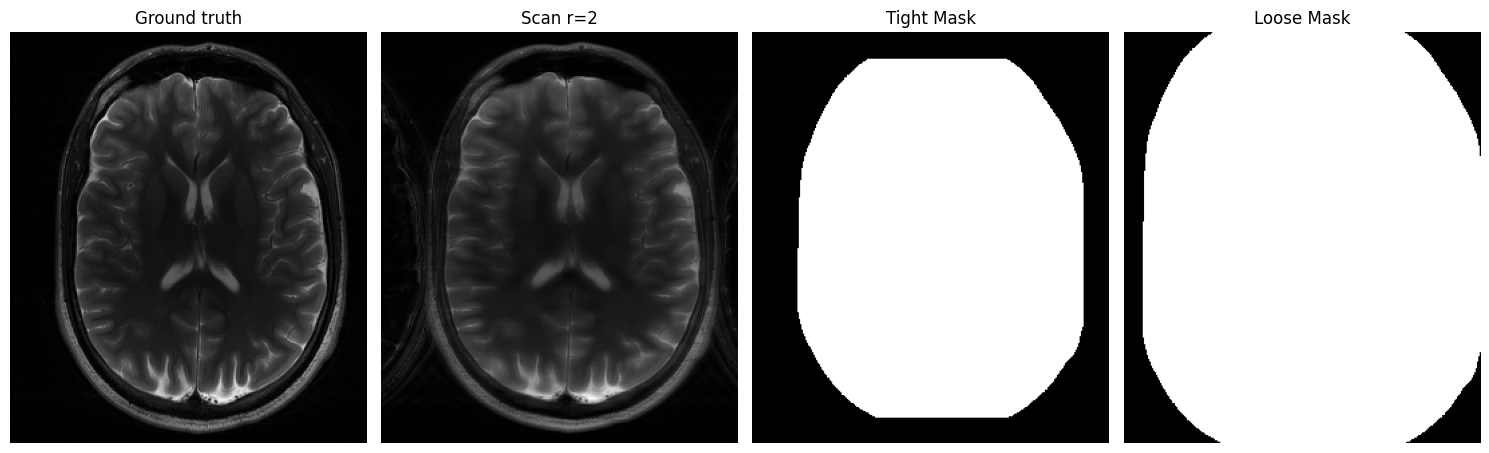

In [6]:
# plot
plt.figure(figsize=(15, 5))

# Original MRI scan
plt.subplot(1, 4, 1)
plt.title("Ground truth")
plt.imshow(r1_image, cmap='gray')
plt.axis('off')

# r2 MRI scan
plt.subplot(1, 4, 2)
plt.title("Scan r=2")
plt.imshow(r2_image, cmap='gray')
plt.axis('off')

# Tight mask
plt.subplot(1, 4, 3)
plt.title("Tight Mask")
plt.imshow(tight_mask, cmap='gray')
plt.axis('off')

# Loose mask
plt.subplot(1, 4, 4)
plt.title("Loose Mask")
plt.imshow(loose_mask, cmap='gray')
plt.axis('off')


plt.tight_layout()
plt.show()


In [7]:
# NRMSE calculation
no_mask_nrmse = calc_NRMSE(r2_image,r1_image)
loose_mask_nrmse = calc_NRMSE(r2_image*loose_mask,r1_image*loose_mask)
tight_mask_nrmse = calc_NRMSE(r2_image*tight_mask,r1_image*tight_mask)

print(f'NRMSE with no mask: {no_mask_nrmse:.3f}')
print(f'NRMSE with loose mask: {loose_mask_nrmse:3f}')
print(f'NRMSE with tight mask: {tight_mask_nrmse:.3f}')

NRMSE with no mask: 0.076
NRMSE with loose mask: 0.074264
NRMSE with tight mask: 0.068


In [123]:
def awgn(s,SNRdB,coils=1,L=1):
    """
    AWGN channel
    Add AWGN noise to input signal. The function adds AWGN noise vector to signal 's' to generate a resulting signal vector 'r' of specified SNR in dB. It also
    returns the noise vector 'n' that is added to the signal 's' and the power spectral density N0 of noise added
    Parameters:
        s : input/transmitted signal vector
        SNRdB : desired signal to noise ratio (expressed in dB) for the received signal
        L : oversampling factor (applicable for waveform simulation) default L = 1.
    Returns:
        r : received signal vector (r=s+n)
        """
    #print(f'shape in : {s.shape}')
    gamma = 10**(SNRdB/10) #SNR to linear scale
    if s.ndim==1:# if s is single dimensional vector
        P=L*sum(abs(s)**2)/len(s)   #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P=L*sum(sum(abs(s)**2))/np.size(s)  #np.size(s) # if s is a matrix [MxN]
    N0=P/gamma # Find the noise spectral density
    if np.isrealobj(s):# check if input is real/complex object type
        n = np.sqrt(N0)*np.random.randn(s.shape[0],s.shape[1],s.shape[2]) # computed noise
    else:
        n = np.sqrt(N0/2)*(np.random.randn(s.shape[0],s.shape[1],s.shape[2])+1j*np.random.randn(s.shape[0],s.shape[1],s.shape[2])) *coils
    r = s + n # received signal
    return r
    

In [9]:
import os
import sys
if 'BART_TOOLBOX_PATH' in os.environ and os.path.exists(os.environ['BART_TOOLBOX_PATH']):
	sys.path.append(os.path.join(os.environ['BART_TOOLBOX_PATH'], 'python'))
elif 'TOOLBOX_PATH' in os.environ and os.path.exists(os.environ['TOOLBOX_PATH']):
	sys.path.append(os.path.join(os.environ['TOOLBOX_PATH'], 'python'))
else:
	raise RuntimeError("BART_TOOLBOX_PATH is not set correctly!")

from bart import bart

In [124]:
SNR = [6,8,10,12,14,16,18,20]
N = 20  # Number of loops for each SNR
NRMSE_results = np.zeros((len(SNR), N)) 
saved_slices = {} 

mask = (np.abs(slice_ksp_r2[:, :, 0]) != 0)
mask = np.repeat(mask[:, :, np.newaxis], 32, axis=2)

image_acc = np.zeros((308,) + (267,) + (32,) + (1,) + (1,) + (1,) + (1,) + (1,) + (1,) + (1,) + (1,) + (1,),complex)
kSpace_acc = np.zeros((308,) + (267,) + (32,) + (1,) + (1,) + (1,) + (1,) + (1,) + (1,) + (1,) + (1,),complex)


for snr_idx, snr in enumerate(SNR):
    for n in range(N):
        slice_rss_noised = awgn(slice_rss_r1_cropped,snr,coils=32,L=1 )
        slice_ksp_noised = fft2c(slice_rss_noised) * mask[166:-166,74:-74]
        
        image_acc[:,:,:,0,0,0,0,0,0,0,0] = ifft2c(slice_ksp_noised)[..., np.newaxis]
        kSpace_acc[:,:,:,0,0,0,0,0,0,0,0] = slice_ksp_noised

        # coils dim change
        kSpace_acc_permute = np.transpose(kSpace_acc, (0, 1, 3, 2, 4, 5, 6, 7, 8, 9, 10))

        #sens maps
        kSpace_map=np.ones(slice_ksp_noised.shape + (1,) + (1,) + (1,) + (1,) + (1,) + (1,) + (1,) + (1,) + (1,) )
        kSpace_acc_map=np.ones((308,) + (267,) + (1,) + (32,)  + (1,) + (1,) + (1,) + (1,) + (1,) + (1,) + (1,) )

        # Reconstruction
        recon = bart(1,'pics -R W:3:0:0.01',kSpace_acc_permute,kSpace_acc_map)
 
        #scale
        slice_gt = np.sqrt(np.sum(np.abs(slice_rss_noised) ** 2, axis=-1)) 
        im_lowres = abs(sp.ifft(sp.resize(sp.resize(np.abs(slice_gt),(256,24)),(256,160))))
        magnitude_vals = im_lowres.reshape(-1)
        k = int(round(0.05 * magnitude_vals.shape[0]))
        scale = magnitude_vals[magnitude_vals.argsort()[::-1][k]]
        slice_gt = slice_gt /scale

        im_lowres_r = abs(sp.ifft(sp.resize(sp.resize(np.abs(recon),(256,24)),(256,160))))
        magnitude_vals_r = im_lowres_r.reshape(-1)
        k_r = int(round(0.05 * magnitude_vals_r.shape[0]))
        scale_r = magnitude_vals_r[magnitude_vals_r.argsort()[::-1][k_r]]
        recon = recon / scale_r

        nrmse_value = calc_NRMSE(np.abs(recon) * tight_mask, np.abs(slice_gt) * tight_mask)
        NRMSE_results[snr_idx, n] = nrmse_value

    saved_slices[snr] = slice_gt   
# Calculate mean and std for each SNR
NRMSE_mean = np.mean(NRMSE_results, axis=1)
NRMSE_std = np.std(NRMSE_results, axis=1)

Size: 82236 Samples: 46507 Acc: 1.77
l1-wavelet regularization: 0.010000
Regularization terms: 1, Supporting variables: 0
FISTA
Total Time: 2.621388
Size: 82236 Samples: 46507 Acc: 1.77
l1-wavelet regularization: 0.010000
Regularization terms: 1, Supporting variables: 0
FISTA
Total Time: 2.258242
Size: 82236 Samples: 46507 Acc: 1.77
l1-wavelet regularization: 0.010000
Regularization terms: 1, Supporting variables: 0
FISTA
Total Time: 2.495758
Size: 82236 Samples: 46507 Acc: 1.77
l1-wavelet regularization: 0.010000
Regularization terms: 1, Supporting variables: 0
FISTA
Total Time: 2.135535
Size: 82236 Samples: 46507 Acc: 1.77
l1-wavelet regularization: 0.010000
Regularization terms: 1, Supporting variables: 0
FISTA
Total Time: 2.333793
Size: 82236 Samples: 46507 Acc: 1.77
l1-wavelet regularization: 0.010000
Regularization terms: 1, Supporting variables: 0
FISTA
Total Time: 2.250158
Size: 82236 Samples: 46507 Acc: 1.77
l1-wavelet regularization: 0.010000
Regularization terms: 1, Supporti

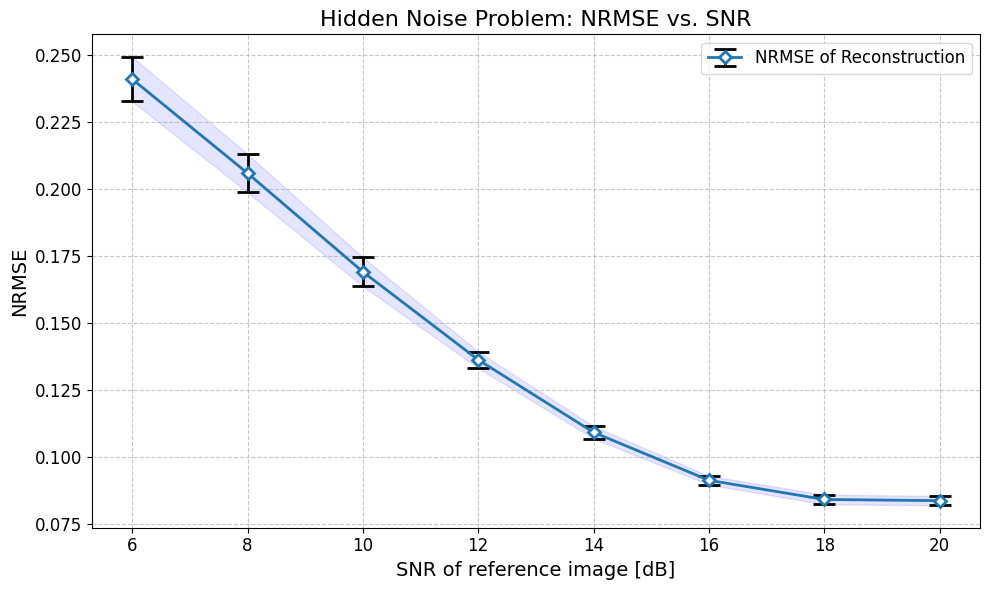

65536.00000000015


In [125]:
plt.figure(figsize=(10, 6))
plt.errorbar(
    SNR,
    NRMSE_mean,
    yerr=NRMSE_std,
    fmt='D',
    markersize=6,
    markerfacecolor='white',
    markeredgewidth=2, 
    linestyle='-',
    linewidth=2,
    color='#1f77b4',        # Line color
    ecolor='black',          # Error bar color
    elinewidth=2,           # Thickness of error bars
    capsize=8,              # Length of error bar caps
    capthick=2,             # Thickness of error bar caps
    label='NRMSE of Reconstruction',
)
plt.fill_between(
    SNR,
    np.array(NRMSE_mean) - np.array(NRMSE_std),
    np.array(NRMSE_mean) + np.array(NRMSE_std),
    color='blue',
    alpha=0.1,
)

plt.xlabel('SNR of reference image [dB]', fontsize=14)
plt.ylabel('NRMSE', fontsize=14)
plt.title('Hidden Noise Problem: NRMSE vs. SNR', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()
plt.show()

print(np.sqrt(2)**32)

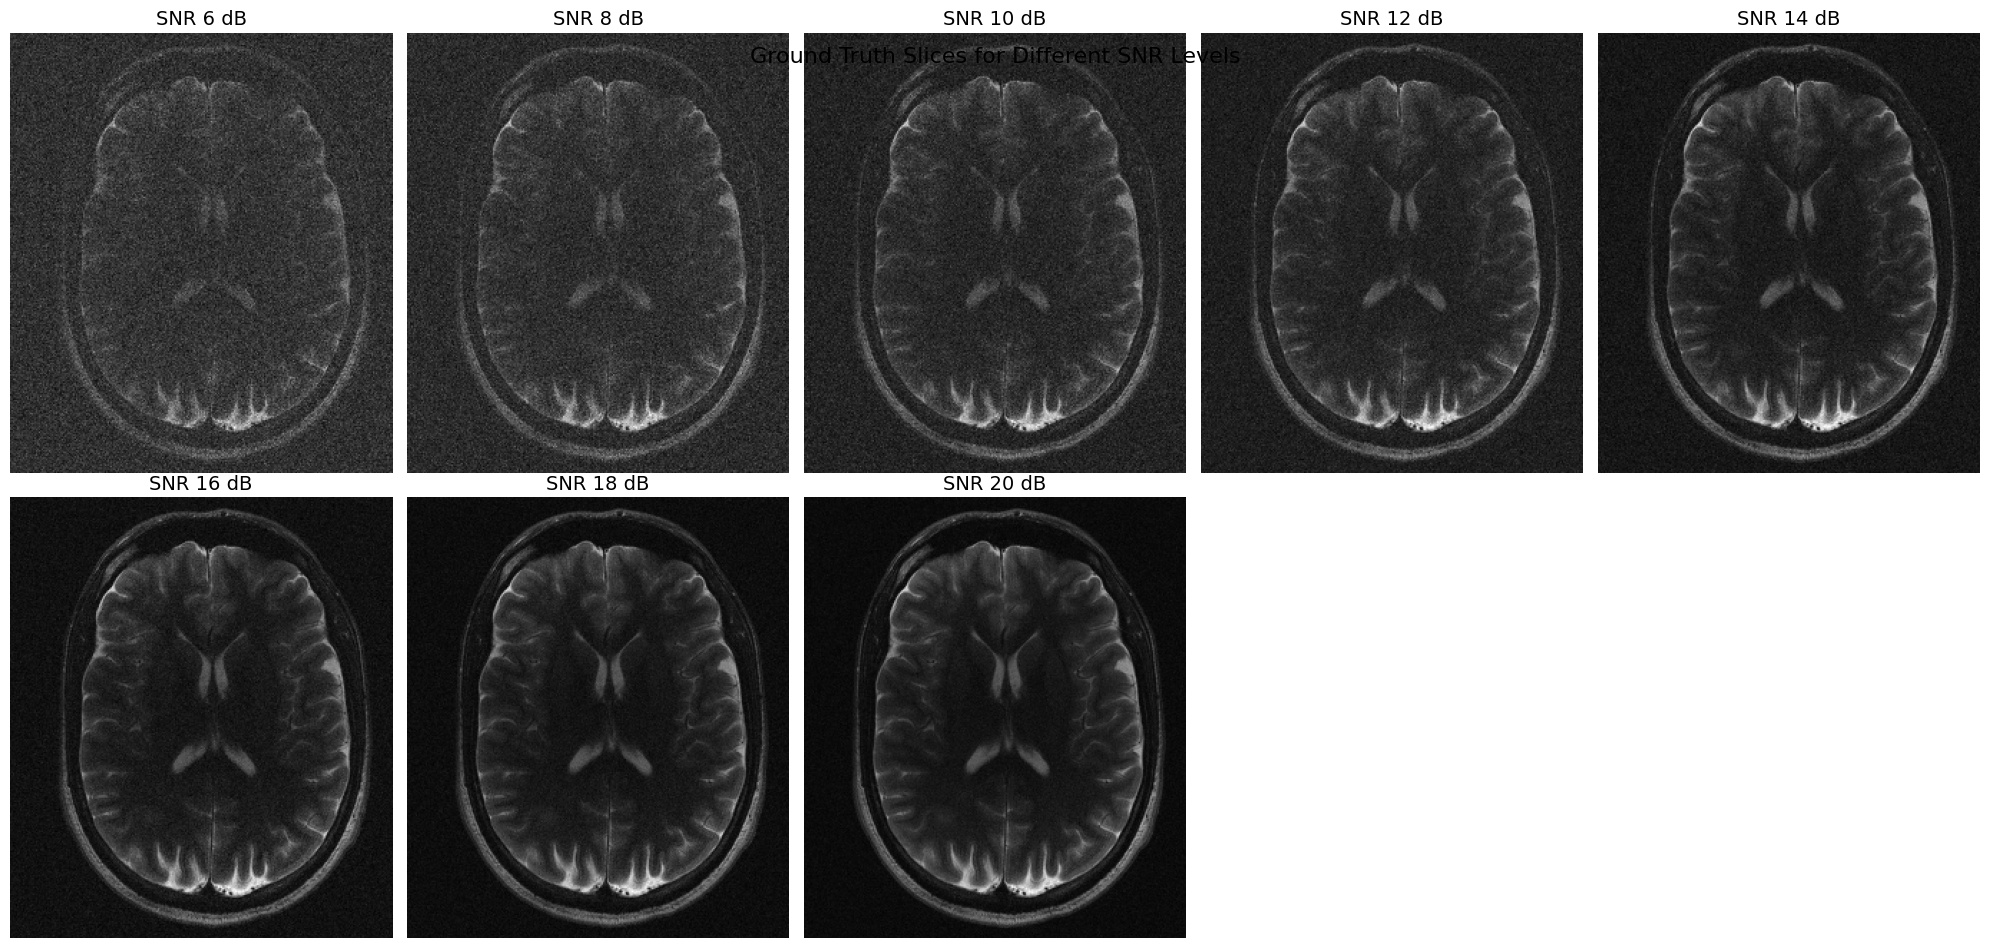

In [126]:
plt.figure(figsize=(20, 10))
columns = len(saved_slices)

for idx, (snr, slice_gt) in enumerate(saved_slices.items(), start=1):
    plt.subplot(2, 5, idx)
    plt.imshow(np.abs(slice_gt), cmap='gray')
    plt.title(f"SNR {snr} dB", fontsize=14)
    plt.axis('off')

plt.suptitle("Ground Truth Slices for Different SNR Levels", fontsize=16, y=0.92)
plt.tight_layout()
plt.show()